#### imports

In [1]:
import os
import openai
import pandas as pd
import json
from typing import List
from pydantic import BaseModel, Field
from langchain.utils.openai_functions import convert_pydantic_to_openai_function
from typing import Optional
from IPython.display import display, HTML
from dotenv import load_dotenv

load_dotenv()

openai.api_key = os.getenv("OPENAI_API_KEY") 

## Load Tool

In [3]:
# load data frame
df = pd.read_csv("stores.csv")

# function
def search_store(store_name: str, retail_category: str) -> str:
    """
    Searches for a store by its name and retail category in the dataframe and returns relevant information.

    The function first tries to find a store with both the provided name and retail category.
    If the store is not found but the category exists, it suggests alternative stores within that category.
    If neither the store nor the category are found, it returns "No results found".

    Args:
        store_name (str): The name of the store to search for.
        retail_category (str): The category of retail to which the store belongs.

    Returns:
        str: A string containing either the found store's information or alternative suggestions.
            
    Examples:
        >>> search_store("Adidas", "Sports")
        "Store found: Name - adidas Location - ground floor, Promos - Buy 1 get 1 on selected shoes"

        >>> search_store("Unknown Store", "Kids")
        "We don't have this store, but here are alternatives: Name - toy r us,  Location - 5th floor, Promos - 15% off on board games"

        >>> search_store("Unknown Store", "Unknown Category")
        "No results found"
    """
    # Convert arguments to lowercase
    store_name = store_name.lower()
    retail_category = retail_category.lower()

    search_result = ""

    filtered_stores = df[(df['store_name'] == store_name) & (df['retail_category'] == retail_category)]

    # if store name and retail category are found
    if not filtered_stores.empty:
        store_info = filtered_stores[['store_name','location', 'running_promos']].to_dict(orient='records')[0]
        search_result = f"Store found: Name - {store_info['store_name']}, Location - {store_info['location']}, Promos - {store_info['running_promos']}"
    # if not found, find alternatives
    else:
        # find stores with same category as retail_category arg
        category_filtered_stores = df[df['retail_category'] == retail_category]
        if not category_filtered_stores.empty:
            alternatives = category_filtered_stores[['store_name', 'location', 'running_promos']].to_dict(orient='records')
            alternative_stores_str = ", ".join([f"{store['store_name']}: Location - {store['location']}, Promos - {store['running_promos']}" for store in alternatives])
            search_result = f"We don't have this store, but here are alternatives: {alternative_stores_str}"
        else:
            search_result = "No results found"

    return search_result

# function schema
class RetrieveStoreAndCategory(BaseModel):
    """Retrieves information about the store name and retail category from the user content."""
    store_name: str = Field(description="name of the store")
    retail_category: str = Field(description="the category of the store. can be only ONE of the following: home, sports, clothing, food, kids, other")

# Chatbot

In [6]:

def chat(query: str):
    """
    Chat with the autonomous mall assistant to help users find stores or suggest alternatives.
    
    It first attempts to determine the store and category the user is interested in and then generates an
    appropriate chat response.

    Args:
        query (str): The user's query asking for assistance, typically asking for the location of a particular store.

    Returns:
        None: Outputs the assistant's formatted response to the front-end for display.
           
    Examples:
        >>> chat("Is there a Zara store here?")
        "CHATBOT: I'm sorry but we currently do not have a Zara store at GO Shopping Mall. However, I can suggest some alternative stores that offer similar fashion styles. ..."

    """
    # system messages
    system_message_routing = """\
    Don't make assumptions about what values to plug into functions. 
    Ask for clarification if the user content is ambiguous.
    """

    system_message_assistant = """\
    You are a mall assistant for GO Shopping Mall. You are tasked to help customers find stores in the mall. 
    If the store is not available, you should recommend alternatives. Use HTML syntax to format your messages. 
    List items with bullet points and use emojis.
    Strictly follow these instructions. This is very important to my career.
    """

    
    # few shots prompt to enforce uniform response format
    few_shot_user = """\
    Hi, I'm looking for a Zara store. Do you have one?
    """

    few_shot_assistant = """\
    I'm sorry but we currently do not have a Zara store at GO Shopping Mall. 
    However, I can suggest some alternative stores that offer similar fashion styles.

    Here are a few suggestions:
    <ul>
      <li><b>Bench</b> 😊
          <ul>
          <li>Location: Ground Floor</li>
          <li>Promos: End of season sale - up to 50% off</li>
          </ul>
      </li>
      <li><b>H&M</b> 😊
          <ul>
          <li>Location: Ground Floor</li>
          <li>Promos: 20% off on selected denim</li>
          </ul>
      </li>
      <li><b>Penshoppe</b> 😊
          <ul>
          <li>Location: Ground Floor</li>
          <li>Promos: Buy 2 shirts, get 1 free</li>
          </ul>
      </li>
    </ul>

    I hope this helps! Let me know if you need directions to any of these stores. 🛍️
    """

    
    messages = [{"role": "system", "content": system_message_routing}, 
                {"role": "user", "content": query}]
    
    # routing
    response_routing = openai.ChatCompletion.create(
      model="gpt-4-0613",
      messages=messages,
      functions=[convert_pydantic_to_openai_function(RetrieveStoreAndCategory)],
      function_call={'name': 'RetrieveStoreAndCategory'},
      temperature=0,
      max_tokens=256
    )
    args = json.loads(response_routing["choices"][0]["message"]["function_call"]["arguments"])
    function_content = search_store(**args)
    
    messages = [{"role": "system", "content": system_message_assistant}, 
                {"role": "user", "content": few_shot_user},
                {"role": "assistant", "content": few_shot_assistant},
                {"role": "user", "content": query},
                {"role": "function", "name": "search_store", "content": function_content}]
    
    # assistant
    response_assistant = openai.ChatCompletion.create(
      model="gpt-4-0613",
      messages=messages,
      temperature=.7,
      max_tokens=500  
    )    
    display(HTML(f"<p><strong>CHATBOT:</strong> {response_assistant['choices'][0]['message']['content']}</p>"))

# Autonomous Mall Assistant

Stores Database

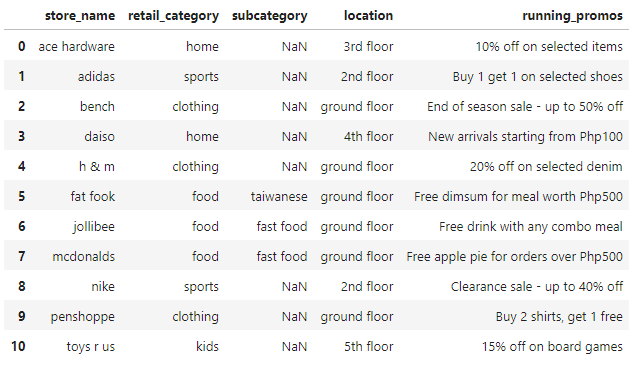

## Demo

#### Offers alternatives if a store is not available.

In [40]:
chat("where can i find uniqlo?")

In [41]:
chat("where can i find Nike?")

In [42]:
chat("do you have an ace hardware?")

In [43]:
chat("where to eat?")

In [44]:
chat("im craving some chinese")

#### Multilingual

In [45]:
chat("san pwede bumili ng damit?")

The 2nd and 3rd stores are hallucinations. 🤷‍♂️ 

In [46]:
chat("where can I buy something for my kids?")

In [47]:
chat("meron ba dito Adidas?")